Importing libraries

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

In [ ]:
%%capture
! pip install -U sentence-transformers

## Dataset loading (GOOGLE COLAB CODE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/NLP_Bocconi/NLP_spoiler'

Mounted at /content/drive


In [ ]:
cl_rev = pd.read_json(f'{path}/data/reduced_cleaned_reviews.json')
cl_rev.head()

,movie_id,clean_text,is_spoiler,title
0,tt0105112,Patriot Games is a more than serviceable thril...,False,Patriot Games
1,tt0105112,I have read all of the Tom Clancy fiction book...,False,Patriot Games
2,tt0105112,When CIA analyst Jack Ryan Harrison Ford inter...,False,Patriot Games
3,tt0105112,Phillip Noyce is Patriot Games is a superb fil...,False,Patriot Games
4,tt0105112,Hello First I do not own a copy of the Patriot...,False,Patriot Games


## Dataset loading (VS Studio)

In [ ]:
cl_rev = pd.read_json('data/reduced_cleaned_reviews.json')
cl_rev.head()

,movie_id,clean_text,is_spoiler,title
0,tt0105112,Patriot Games is a more than serviceable thril...,False,Patriot Games
1,tt0105112,I have read all of the Tom Clancy fiction book...,False,Patriot Games
2,tt0105112,When CIA analyst Jack Ryan Harrison Ford inter...,False,Patriot Games
3,tt0105112,Phillip Noyce is Patriot Games is a superb fil...,False,Patriot Games
4,tt0105112,Hello First I do not own a copy of the Patriot...,False,Patriot Games


## Feature Engineering already computed, please start running from Train-dev-test split

### Resources NLTK

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to

[nltk_data]     /Users/mattia/nltk_data...

[nltk_data]   Package averaged_perceptron_tagger is already up-to-

[nltk_data]       date!


True

In [ ]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to

[nltk_data]     /Users/mattia/nltk_data...

[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [ ]:
nltk.download('words')

[nltk_data] Downloading package words to /Users/mattia/nltk_data...

[nltk_data]   Package words is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mattia/nltk_data...

[nltk_data]   Package punkt is already up-to-date!


True

### Features

Review length

In [ ]:
# Review length (number of words and characters)
cl_rev['review_length_words'] = np.nan
cl_rev['review_length_chars'] = np.nan
for i in range(len(cl_rev)):
    review = cl_rev['clean_text'][i]
    words = word_tokenize(review)
    cl_rev.iloc[i, cl_rev.columns.get_loc('review_length_words')] = len(words)
    cl_rev.iloc[i, cl_rev.columns.get_loc('review_length_chars')] = len(review)

Sentiment score

In [ ]:
# Sentiment score
cl_rev['sentiment_polarity'] = np.nan
cl_rev['sentiment_subjectivity'] = np.nan
for i in range(len(cl_rev)):
    review = cl_rev['clean_text'][i]
    sentiment = TextBlob(review).sentiment
    cl_rev.iloc[i, cl_rev.columns.get_loc('sentiment_polarity')] = sentiment.polarity
    cl_rev.iloc[i, cl_rev.columns.get_loc('sentiment_subjectivity')] = sentiment.subjectivity

Keywords

In [ ]:
# Presence of keywords
keywords = ["plot twist", "ending", "finale"]
for keyword in keywords:
    cl_rev[f'keyword_{keyword.replace(" ", "_")}'] = np.nan
for i in range(len(cl_rev)):
    review = cl_rev['clean_text'][i]
    for keyword in keywords:
        cl_rev.iloc[i, cl_rev.columns.get_loc(f'keyword_{keyword.replace(" ", "_")}')] = int(keyword in review.lower())

NER

In [ ]:
from nltk import tree2conlltags

# Named Entity Recognition (NER)
cl_rev['ner_count'] = np.nan

for i in range(len(cl_rev)):
    review = cl_rev['clean_text'][i]
    words = word_tokenize(review)
    entities = nltk.ne_chunk(nltk.pos_tag(words))
    iob_tagged = tree2conlltags(entities)
    tagged_text = []
    for word, pos, ne_tag in iob_tagged:
        if ne_tag != 'O':  # If the word is part of a named entity
            tagged_word = f"{word}_{ne_tag[2:]}"
        else:
            tagged_word = word
        tagged_text.append(tagged_word)

    # Join the tagged words into a single string
    tagged_text_str = ' '.join(tagged_text)
    cl_rev.loc[i, 'ner_count'] = sum(1 for chunk in entities if hasattr(chunk, 'label'))
    cl_rev.loc[i, 'ner_text'] = tagged_text_str

In [ ]:
# cl_rev.to_csv(f'{path}/data/reduced_reviews_meta_features_NER.csv')
cl_rev.to_csv('data/reduced_reviews_meta_features_NER.csv')

## Train - Dev - Test Split

In [ ]:
cl_rev = pd.read_csv(f'{path}/data/reduced_reviews_meta_features_NER.csv')

In [ ]:
X = cl_rev[['clean_text', 'is_spoiler', 'review_length_words', 'review_length_chars',
            'sentiment_polarity', 'sentiment_subjectivity', 'keyword_plot_twist',
            'keyword_ending', 'keyword_finale', 'ner_count', 'ner_text']]
train, testing = train_test_split(X, test_size=0.2, random_state=42)
dev, test = train_test_split(testing, test_size=0.5, random_state=42)

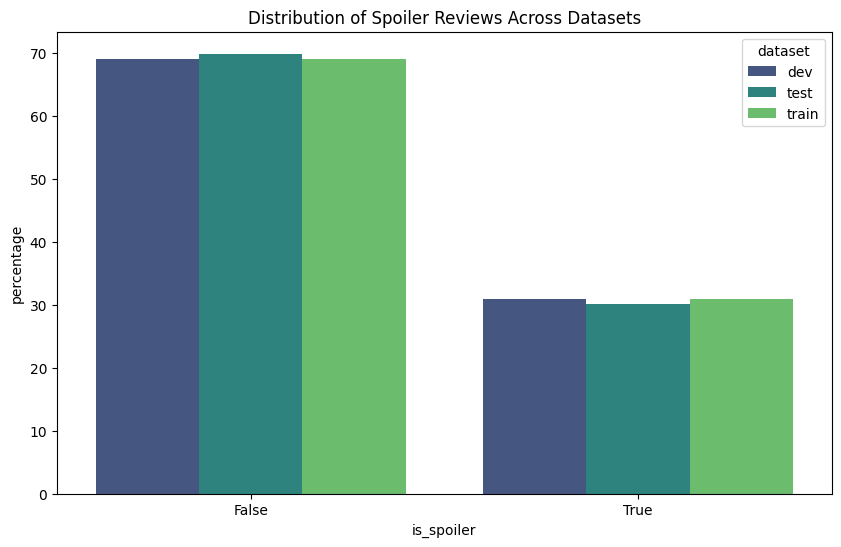

In [ ]:
train['dataset'] = 'train'
dev['dataset'] = 'dev'
test['dataset'] = 'test'

# Combine the dataframes
combined_data = pd.concat([train, dev, test])
# Calculate percentage
percentage_data = combined_data.groupby('dataset')['is_spoiler'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x='is_spoiler', y='percentage', hue='dataset', data=percentage_data, palette='viridis')
plt.title('Distribution of Spoiler Reviews Across Datasets')
plt.show()

In [ ]:
train = pd.DataFrame(train).reset_index(drop=True)
dev = pd.DataFrame(dev).reset_index(drop=True)
test = pd.DataFrame(test).reset_index(drop=True)

## Embeddings T5

computes the t5 embeddings if not available otherwise it loads the existing ones




In [ ]:
from sentence_transformers import SentenceTransformer

def embed_text():

  if not os.path.exists(f'{path}/data/embedding_cache_path_NER.npy'):
    print('Start calculating embeddings...')
    model = SentenceTransformer('sentence-transformers/sentence-t5-base')

    print(f'... using {model}')
    embeddings = model.encode(train['ner_text'], show_progress_bar = True)
    val_embeddings = model.encode(dev['ner_text'], show_progress_bar = True)
    test_embeddings = model.encode(test['ner_text'], show_progress_bar = True)

    emb = np.concatenate((embeddings, val_embeddings, test_embeddings))
    np.save(f'{path}/data/embedding_cache_path_NER.npy', emb)
  else:
    print('Loading existing embeddings...')
    emb = np.load(f'{path}/data/embedding_cache_path_NER.npy')
    embeddings, val_embeddings, test_embeddings = emb[:len(train)], emb[len(train):len(train) + len(dev)], emb[len(train) + len(dev) : ]
  return embeddings, val_embeddings, test_embeddings

In [ ]:
embeddings, val_embeddings, test_embeddings = embed_text()

Loading existing embeddings...


## T5 - Logistic

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler

cls = LogisticRegression(n_jobs=-1, random_state=42, max_iter = 5000,class_weight = 'balanced')#, C = 0.9)

tr = train[['review_length_words', 'review_length_chars',
            'sentiment_polarity', 'sentiment_subjectivity', 'keyword_plot_twist',
            'keyword_ending', 'keyword_finale', 'ner_count']].to_numpy()
d = dev[['review_length_words', 'review_length_chars',
            'sentiment_polarity', 'sentiment_subjectivity', 'keyword_plot_twist',
            'keyword_ending', 'keyword_finale', 'ner_count']].to_numpy()
te = test[['review_length_words', 'review_length_chars',
            'sentiment_polarity', 'sentiment_subjectivity', 'keyword_plot_twist',
            'keyword_ending', 'keyword_finale', 'ner_count']].to_numpy()

X_train = np.hstack((tr, embeddings))
X_dev = np.hstack((d, val_embeddings))
X_test = np.hstack((te, test_embeddings))

y_train = train['is_spoiler'].to_numpy()
y_dev = dev['is_spoiler'].to_numpy()
y_test = test['is_spoiler'].to_numpy()

#scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

cls.fit(X_train, y_train)

train_predictions = cls.predict(X_train)
print('Train performance:')
print(classification_report(y_train, train_predictions))

predictions = cls.predict(X_dev)

# performance report
print('Dev performance:')
print(classification_report(y_dev, predictions))
print(f1_score(y_dev, predictions, average='macro'))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Train performance:
              precision    recall  f1-score   support

       False       0.82      0.68      0.74     64810
        True       0.48      0.66      0.55     28962

    accuracy                           0.67     93772
   macro avg       0.65      0.67      0.65     93772
weighted avg       0.71      0.67      0.68     93772

Dev performance:
              precision    recall  f1-score   support

       False       0.82      0.68      0.74      8104
        True       0.48      0.66      0.56      3618

    accuracy                           0.68     11722
   macro avg       0.65      0.67      0.65     11722
weighted avg       0.71      0.68      0.69     11722

0.6496474920067212


In [ ]:
predictions = cls.predict(X_test)

# performance report
print('Test performance:')
print(classification_report(y_test, predictions))
print(f1_score(y_test, predictions, average='macro'))

Test performance:
              precision    recall  f1-score   support

       False       0.81      0.68      0.74      8196
        True       0.46      0.63      0.53      3526

    accuracy                           0.67     11722
   macro avg       0.63      0.66      0.64     11722
weighted avg       0.70      0.67      0.68     11722

0.6355070467553101


In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, predictions)
print(f"The AUC is: {auc}")

The AUC is: 0.6553956566669075


## T5 - XGBoost

In [ ]:
%%capture
!pip install xgboost

In [ ]:
tr = train[['review_length_words', 'review_length_chars',
            'sentiment_polarity', 'sentiment_subjectivity', 'keyword_plot_twist',
            'keyword_ending', 'keyword_finale', 'ner_count']].to_numpy()
d = dev[['review_length_words', 'review_length_chars',
            'sentiment_polarity', 'sentiment_subjectivity', 'keyword_plot_twist',
            'keyword_ending', 'keyword_finale', 'ner_count']].to_numpy()
te = test[['review_length_words', 'review_length_chars',
            'sentiment_polarity', 'sentiment_subjectivity', 'keyword_plot_twist',
            'keyword_ending', 'keyword_finale', 'ner_count']].to_numpy()

X_train = np.hstack((tr, embeddings))
X_dev = np.hstack((d, val_embeddings))
X_test = np.hstack((te, test_embeddings))

y_train = train['is_spoiler'].to_numpy()
y_dev = dev['is_spoiler'].to_numpy()
y_test = test['is_spoiler'].to_numpy()

# scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

cls = xgb.XGBClassifier(n_estimators=500, max_depth=3, learning_rate=0.1,
                        subsample=0.8, colsample_bytree=0.8, n_jobs=-1,
                        random_state=42, use_label_encoder=False, eval_metric='logloss')

cls.fit(X_train, y_train, eval_set=[(X_dev, y_dev)], early_stopping_rounds=10, verbose=False)


# performance report on validation
predictions = cls.predict(X_dev)
print('Dev performance:')
print(classification_report(y_dev, predictions))
print(f1_score(y_dev, predictions, average='macro'))

# performance report on validation
predictions = cls.predict(X_test)
print('Test performance:')
print(classification_report(y_test, predictions))
print(f1_score(y_test, predictions, average='macro'))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Dev performance:
              precision    recall  f1-score   support

       False       0.74      0.93      0.82      8104
        True       0.62      0.25      0.36      3618

    accuracy                           0.72     11722
   macro avg       0.68      0.59      0.59     11722
weighted avg       0.70      0.72      0.68     11722

0.5888153706401035
Dev performance:
              precision    recall  f1-score   support

       False       0.74      0.93      0.82      8196
        True       0.59      0.23      0.34      3526

    accuracy                           0.72     11722
   macro avg       0.67      0.58      0.58     11722
weighted avg       0.69      0.72      0.68     11722

0.5792934384073698


# Bidirectional GRU

In [ ]:
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, LSTM
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
cl_rev = pd.read_csv(f'{path}/data/reduced_reviews_meta_features_NER.csv')
cl_rev.head()

,Unnamed: 0,movie_id,clean_text,is_spoiler,title,review_length_words,review_length_chars,sentiment_polarity,sentiment_subjectivity,keyword_plot_twist,keyword_ending,keyword_finale,ner_count,ner_text
0,0,tt0105112,Patriot Games is a more than serviceable thril...,False,Patriot Games,198.0,1034.0,0.121775,0.561957,0.0,0.0,0.0,6.0,Patriot_PERSON Games is a more than serviceabl...
1,1,tt0105112,I have read all of the Tom Clancy fiction book...,False,Patriot Games,162.0,821.0,0.158854,0.420833,0.0,1.0,0.0,6.0,I have read all of the Tom_ORGANIZATION Clancy...
2,2,tt0105112,When CIA analyst Jack Ryan Harrison Ford inter...,False,Patriot Games,127.0,709.0,0.495238,0.661905,0.0,0.0,0.0,16.0,When CIA_ORGANIZATION analyst Jack_PERSON Ryan...
3,3,tt0105112,Phillip Noyce is Patriot Games is a superb fil...,False,Patriot Games,156.0,854.0,0.388889,0.628241,0.0,0.0,0.0,17.0,Phillip_PERSON Noyce_ORGANIZATION is Patriot_O...
4,4,tt0105112,Hello First I do not own a copy of the Patriot...,False,Patriot Games,119.0,601.0,0.136762,0.606913,0.0,0.0,0.0,7.0,Hello_PERSON First I do not own a copy of the ...


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
# Sample data
texts = cl_rev.ner_text
labels = cl_rev.is_spoiler
movie_titles = cl_rev.title

# Tokenization
max_vocab_size = 20000
max_sequence_length = 200
max_title_length = 20

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Padding
data = pad_sequences(sequences, maxlen=max_sequence_length)

# Tokenize and pad movie title data
title_tokenizer = Tokenizer(num_words=max_vocab_size)
title_tokenizer.fit_on_texts(movie_titles)
title_sequences = title_tokenizer.texts_to_sequences(movie_titles)
title_data = pad_sequences(title_sequences, maxlen=max_title_length)

# Define meta features
meta_features = cl_rev[['review_length_words', 'review_length_chars',
            'sentiment_polarity', 'sentiment_subjectivity', 'keyword_plot_twist',
            'keyword_ending', 'keyword_finale', 'ner_count']].to_numpy()

# Standardize the meta features in the datasets
scaler = StandardScaler()
scaler.fit_transform(meta_features)

# Train-test split
X_train, X_test, title_train, title_test, meta_train, meta_test, y_train, y_test = train_test_split(
    data, title_data, meta_features, labels, test_size=0.2, random_state=42)

# Prepare labels
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

# Reshape labels
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU")
else:
    print("TensorFlow will run on CPU")

Num GPUs Available:  1
TensorFlow will run on GPU


In [ ]:
# Model definition
embedding_dim = 300

# Text input
text_input = Input(shape=(max_sequence_length,), name='text_input')
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim)(text_input)
bi_gru = Bidirectional(GRU(128, return_sequences=True))(embedding_layer)
dropout_1 = Dropout(0.4)(bi_gru)
gru_output = GRU(64)(dropout_1)

# Meta features input
meta_input = Input(shape=(meta_features.shape[1],), name='meta_input')

# Movie title input
title_input = Input(shape=(max_title_length,), name='title_input')
title_embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim)(title_input)
title_embedding = GlobalMaxPooling1D()(title_embedding_layer)

# Concatenate text, title, and meta features
concatenated = Concatenate()([gru_output, title_embedding, meta_input])

# Fully connected layers
dense_1 = Dense(64, activation='relu')(concatenated)
dropout_2 = Dropout(0.3)(dense_1)
dense_2 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dropout_2)

# Define and compile the model
gru_model = Model(inputs=[text_input, title_input, meta_input], outputs=output)

# Compile the model
gru_model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.F1Score( average='macro', threshold=0.5), Recall(), Precision()])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = gru_model.fit(
    {'text_input': X_train, 'title_input' : title_train, 'meta_input': meta_train},
    y_train,
    epochs=15,
    batch_size=16,
    validation_split=0.1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping])

# Evaluate model performance
loss, f1, precision, recall = gru_model.evaluate({'text_input': X_test, 'title_input' : title_test, 'meta_input': meta_test}, y_test)
print(f"Test Loss: {loss}")
print(f"Test F1-Score: {f1}, Test Precision: {precision}, Test Recall: {recall}")

# Make predictions
predictions = gru_model.predict({'text_input': X_test,  'title_input' : title_test, 'meta_input': meta_test})
binary_predictions = (predictions >= 0.5).astype(int)

# Generate classification report
class_report = classification_report(y_test, binary_predictions)
print("\nClassification Report:")
print(class_report)

Epoch 1/15
5275/5275 [==============================] - 185s 34ms/step - loss: 13.2989 - f1_score: 0.4000 - recall: 0.5112 - precision: 0.3286 - val_loss: 0.7099 - val_f1_score: 0.4757 - val_recall: 0.6363 - val_precision: 0.3798
Epoch 2/15
5275/5275 [==============================] - 128s 24ms/step - loss: 0.6770 - f1_score: 0.4623 - recall: 0.5815 - precision: 0.3837 - val_loss: 0.7033 - val_f1_score: 0.4942 - val_recall: 0.7496 - val_precision: 0.3686
Epoch 3/15
5275/5275 [==============================] - 129s 24ms/step - loss: 0.6739 - f1_score: 0.4748 - recall: 0.6219 - precision: 0.3840 - val_loss: 0.6780 - val_f1_score: 0.4742 - val_recall: 0.5944 - val_precision: 0.3944
Epoch 4/15
5275/5275 [==============================] - 127s 24ms/step - loss: 0.6725 - f1_score: 0.4772 - recall: 0.6267 - precision: 0.3853 - val_loss: 0.6581 - val_f1_score: 0.4680 - val_recall: 0.5535 - val_precision: 0.4054
Epoch 5/15
5275/5275 [==============================] - 129s 24ms/step - loss: 0.66

In [ ]:
gru_model.save(f'{path}/data/GRU_meta_features')

In [ ]:
from tensorflow.keras.models import load_model

gru_model = load_model(f'{path}/data/GRU_meta_features')


# Custom DistilBert

In [ ]:
cl_rev = pd.read_csv(f'{path}/data/reduced_reviews_meta_features_NER.csv')

In [ ]:
%%capture
!pip uninstall accelerate -U
!pip install --upgrade accelerate -U
! pip install transformers

Incorporate title into the review

In [ ]:
cl_rev['review'] = 'Movie title: ' + cl_rev["title"] + '\n' + cl_rev['clean_text']


In [ ]:
import torch
from torch.utils.data import Dataset, random_split
from transformers import DistilBertTokenizer, DistilBertModel, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
from sklearn.metrics import f1_score, precision_recall_fscore_support
from collections import Counter
import random
from sklearn.preprocessing import StandardScaler

class SpoilerDataset(Dataset):
    def __init__(self, reviews, labels, additional_features, tokenizer, review_max_length=512):
        self.reviews = reviews
        self.labels = labels
        self.additional_features = additional_features
        self.tokenizer = tokenizer
        self.review_max_length = review_max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        review = self.reviews[idx]

        review_tokens = self.tokenizer(review, max_length=self.review_max_length, truncation=True, padding='max_length', return_tensors="pt")

        input_ids = review_tokens['input_ids'].squeeze(0)
        attention_mask = review_tokens['attention_mask'].squeeze(0)

        item = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'additional_features': torch.tensor(self.additional_features[idx], dtype=torch.float32),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float32)
        }
        return item

# Example usage
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')



# Assuming cl_rev is a DataFrame, ensure additional_features is a list of lists
reviews = cl_rev.review.tolist()
labels = cl_rev.is_spoiler.tolist()
additional_features = cl_rev[['review_length_words', 'review_length_chars', 'sentiment_polarity',
                              'sentiment_subjectivity', 'keyword_plot_twist', 'keyword_ending',
                              'keyword_finale', 'ner_count']].values.tolist()

# Create dataset
dataset = SpoilerDataset(reviews, labels, additional_features, tokenizer, review_max_length=512)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator1 = torch.Generator().manual_seed(42)
train_dataset, validation = random_split(dataset, [train_size, val_size], generator=generator1)
val_dataset, test_dataset = random_split(validation, [0.5,0.5], generator=generator1)

# Extract additional features from the training dataset
additional_features_train = [item['additional_features'] for item in train_dataset]
# Fit the scaler
scaler = StandardScaler()
scaler.fit(additional_features_train)
# Standardize additional features for training data
for item in train_dataset:
    item['additional_features'] = scaler.transform([item['additional_features']])[0]
# Standardize additional features for validation data
for item in val_dataset:
    item['additional_features'] = scaler.transform([item['additional_features']])[0]
# Standardize additional features for test data
for item in test_dataset:
    item['additional_features'] = scaler.transform([item['additional_features']])[0]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on device {device}')

# Extract labels from the training dataset
train_labels = [train_dataset[i]['labels'].item() for i in range(len(train_dataset))]

# Compute class frequencies
label_counts = Counter(train_labels)
total_samples = len(train_labels)

# Calculate class weights as the inverse of class frequencies
class_weights = {label: total_samples / count for label, count in label_counts.items()}

# Convert class weights to list
class_weights_list = [class_weights[0], class_weights[1]]

print("Class Weights:", class_weights_list)

Running on device cuda
Class Weights: [1.4471880980307426, 3.236195472114854]


In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, Trainer, TrainingArguments
from sklearn.metrics import f1_score, precision_recall_fscore_support

class SpoilerClassifier(nn.Module):
    def __init__(self, distilbert_model, additional_feature_count, class_weights):
        super(SpoilerClassifier, self).__init__()
        self.distilbert = distilbert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Sequential(
            nn.Linear(768 + additional_feature_count, 128),
            nn.ReLU(),  # ReLU activation
            nn.BatchNorm1d(128),  #  Batch Normalization
            nn.Dropout(0.5),  #   dropout layer
            )
        self.output = nn.Linear(128, 1)
        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask, additional_features=None, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Get the CLS token output

        combined_features = torch.cat((pooled_output, additional_features), dim=1)

        #combined_features = self.dropout(combined_features)
        logits = self.classifier(combined_features)
        logits_drop = self.dropout(logits)
        out = self.output(logits_drop).squeeze(-1)

        loss = None
        if labels is not None:
            class_weights = torch.tensor(self.class_weights, dtype=torch.float).to(input_ids.device)
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
            loss = loss_fct(out, labels.float())

        return SequenceClassifierOutput(
            loss=loss,
            logits=out
        )

class DataCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        additional_features = torch.stack([item['additional_features'] for item in batch]) if 'additional_features' in batch[0] else None
        labels = torch.stack([item['labels'] for item in batch])
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'additional_features': additional_features,
            'labels': labels
        }

data_collator = DataCollator()
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    gradient_accumulation_steps=4
)
def compute_metrics(predictions_in):
    labels = predictions_in.label_ids
    logits = predictions_in.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds_binary = (probs > 0.5).astype(int)

    macro_f1 = f1_score(y_true=labels, y_pred=preds_binary, average='macro')
    precision, recall, _, _ = precision_recall_fscore_support(y_true=labels, y_pred=preds_binary, average='macro')

    print(f'F1-score: {macro_f1}, Recall: {recall}')

    return {'macro_f1': macro_f1, 'recall': recall}

# Define the model
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
model = SpoilerClassifier(distilbert, 8, class_weights_list)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator)

# Train the model
trainer.train()

Step,Training Loss
500,1.108300
1000,1.039800
1500,1.028300
2000,0.980100
2500,0.976400
3000,0.955700
3500,0.861900
4000,0.852400
4500,0.821900
5000,0.683100


TrainOutput(global_step=7325, training_loss=0.81546318809327, metrics={'train_runtime': 8194.4421, 'train_samples_per_second': 57.217, 'train_steps_per_second': 0.894, 'total_flos': 0.0, 'train_loss': 0.81546318809327, 'epoch': 4.999146903258829})

In [ ]:
torch.save(model, f'{path}/data/distilbert_w_features3')

In [ ]:
model_trial = torch.load(f'{path}/data/distilbert_w_features3')

In [ ]:
# Define the trainer for evaluation
eval_trainer = Trainer(
    model=model_trial,
    data_collator=data_collator
)

# Make predictions on the test dataset
predictions = eval_trainer.predict(val_dataset)
logits = predictions.predictions

# Convert logits to probabilities using sigmoid and then to binary values
probs = torch.sigmoid(torch.tensor(logits)).numpy()
preds_binary = (probs > 0.5).astype(int)

# Compute and print metrics
labels = predictions.label_ids

# Compute classification report
report = classification_report(labels, preds_binary)
print(report)

              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76      8126
         1.0       0.49      0.60      0.54      3596

    accuracy                           0.68     11722
   macro avg       0.64      0.66      0.65     11722
weighted avg       0.71      0.68      0.69     11722



In [ ]:

# Define the trainer for evaluation
eval_trainer = Trainer(
    model=model_trial,
    data_collator=data_collator
)

# Make predictions on the test dataset
predictions = eval_trainer.predict(test_dataset)
logits = predictions.predictions

# Convert logits to probabilities using sigmoid and then to binary values
probs = torch.sigmoid(torch.tensor(logits)).numpy()
preds_binary = (probs > 0.5).astype(int)

# Compute and print metrics
labels = predictions.label_ids

# Compute classification report
report = classification_report(labels, preds_binary)
print(report)


              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76      8188
         1.0       0.48      0.58      0.53      3534

    accuracy                           0.68     11722
   macro avg       0.64      0.65      0.64     11722
weighted avg       0.70      0.68      0.69     11722



# GPT-rephrased reviews prediction

In [ ]:
gpt_reviews = pd.read_csv(f'{path}/data/openai_reviews_backup.csv').reset_index(drop = True)
gpt_reviews.head()

,movie_id,plot_summary,genre,release_date,plot_synopsis,title,review_date,user_id,is_spoiler,review_text,rephrased_review,masked_review,non_masked_review
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...","['Action', 'Thriller']",1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",Giochi di potere,5 March 2008,ur16517420,True,The second Tom Clancy novel made into a film (...,In the second film adaptation of a Tom Clancy ...,The second Tom Clancy novel made into a film (...,The second Tom Clancy novel made into a film (...
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",['Comedy'],2013-11-01,Four boys around the age of 10 are friends in ...,Last Vegas,2 June 2014,ur5291991,True,Last Vegas is a comedy that features an ensemb...,"""Last Vegas"" is a comedy featuring a star-stud...",Last Vegas is a comedy that features an ensemb...,Last Vegas is a comedy that features an ensemb...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...","['Comedy', 'Romance']",2002-04-11,NaN,Wet Hot American Summer,28 July 2015,ur3728510,True,"""Not ANOTHER 'Another Teen Movie,'"" is the acc...","""Wet Hot American Summer"" is a film that defie...","""Not ANOTHER 'Another Teen Movie,'"" is the acc...","""Not ANOTHER 'Another Teen Movie,'"" is the acc..."
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...","['Adventure', 'Drama', 'Western']",1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...,Il tesoro della Sierra Madre,27 June 2004,ur1406078,True,John Huston's genius as a director is undeniab...,John Huston's talent as a director shines thro...,John Huston's genius as a director is undeniab...,John Huston's genius as a director is undeniab...
4,tt0126886,Tracy Flick is running unopposed for this year...,"['Comedy', 'Drama', 'Romance']",1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...,Election,16 January 2009,ur8239592,True,"Popular, but frustrated high school civics tea...","In this sharp and witty high school comedy, a ...","Popular, but frustrated high school civics tea...","Popular, but frustrated high school civics tea..."


In [ ]:
original_revs = gpt_reviews[gpt_reviews.rephrased_review.isna()].review_text[:93]

In [ ]:
gpt_reviews.dropna(subset = 'rephrased_review', inplace = True)

In [ ]:
gpt_temp = pd.DataFrame(pd.concat([gpt_reviews['rephrased_review'], original_revs],  axis = 0), columns = ['reviews']).reset_index(drop = True)
gpt_temp.head()

,reviews
0,In the second film adaptation of a Tom Clancy ...
1,"""Last Vegas"" is a comedy featuring a star-stud..."
2,"""Wet Hot American Summer"" is a film that defie..."
3,John Huston's talent as a director shines thro...
4,"In this sharp and witty high school comedy, a ..."


In [ ]:
labels = np.ones(186, dtype = bool)
labels[:93] = 0
gpt_temp['is_spoiler'] = labels

In [ ]:
gpt_temp

,reviews,is_spoiler
0,In the second film adaptation of a Tom Clancy ...,False
1,"""Last Vegas"" is a comedy featuring a star-stud...",False
2,"""Wet Hot American Summer"" is a film that defie...",False
3,John Huston's talent as a director shines thro...,False
4,"In this sharp and witty high school comedy, a ...",False
...,...,...
181,**Warning! Mild Spoilers Ahead!!**The premise ...,True
182,'The Pianist' is definitively an inspiring epi...,True
183,Stand By Me is without a doubt one of the fine...,True
184,Minor SpoilersPredator 2 is a great sequel.The...,True


## Meta features

### Resources NLTK

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [ ]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Features

Review length

In [ ]:
# Review length (number of words and characters)
gpt_temp['review_length_words'] = np.nan
gpt_temp['review_length_chars'] = np.nan
for i in range(len(gpt_temp)):
    review = gpt_temp['reviews'][i]
    words = word_tokenize(review)
    gpt_temp.iloc[i, gpt_temp.columns.get_loc('review_length_words')] = len(words)
    gpt_temp.iloc[i, gpt_temp.columns.get_loc('review_length_chars')] = len(review)

Sentiment score

In [ ]:
# Sentiment score
gpt_temp['sentiment_polarity'] = np.nan
gpt_temp['sentiment_subjectivity'] = np.nan
for i in range(len(gpt_temp)):
    review = gpt_temp['reviews'][i]
    sentiment = TextBlob(review).sentiment
    gpt_temp.iloc[i, gpt_temp.columns.get_loc('sentiment_polarity')] = sentiment.polarity
    gpt_temp.iloc[i, gpt_temp.columns.get_loc('sentiment_subjectivity')] = sentiment.subjectivity

Keywords

In [ ]:
# Presence of keywords
keywords = ["plot twist", "ending", "finale"]
for keyword in keywords:
    gpt_temp[f'keyword_{keyword.replace(" ", "_")}'] = np.nan
for i in range(len(gpt_temp)):
    review = gpt_temp['reviews'][i]
    for keyword in keywords:
        gpt_temp.iloc[i, gpt_temp.columns.get_loc(f'keyword_{keyword.replace(" ", "_")}')] = int(keyword in review.lower())

NER

In [ ]:
from nltk import tree2conlltags

# Named Entity Recognition (NER)
gpt_temp['ner_count'] = np.nan

for i in range(len(gpt_temp)):
    review = gpt_temp['reviews'][i]
    words = word_tokenize(review)
    entities = nltk.ne_chunk(nltk.pos_tag(words))
    iob_tagged = tree2conlltags(entities)
    tagged_text = []
    for word, pos, ne_tag in iob_tagged:
        if ne_tag != 'O':  # If the word is part of a named entity
            tagged_word = f"{word}_{ne_tag[2:]}"
        else:
            tagged_word = word
        tagged_text.append(tagged_word)

    # Join the tagged words into a single string
    tagged_text_str = ' '.join(tagged_text)
    gpt_temp.loc[i, 'ner_count'] = sum(1 for chunk in entities if hasattr(chunk, 'label'))
    gpt_temp.loc[i, 'ner_text'] = tagged_text_str

In [ ]:
gpt_temp.to_csv(f'{path}/data/openai_reviews_meta_features_NER.csv')

## Prediction

In [ ]:
gpt_temp = pd.read_csv(f'{path}/data/openai_reviews_meta_features_NER.csv')

In [ ]:
from sentence_transformers import SentenceTransformer

gpt_model = SentenceTransformer('sentence-transformers/sentence-t5-base')
gpt_embeddings = model.encode(gpt_temp['reviews'], show_progress_bar = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
te = gpt_temp[['review_length_words', 'review_length_chars',
            'sentiment_polarity', 'sentiment_subjectivity', 'keyword_plot_twist',
            'keyword_ending', 'keyword_finale', 'ner_count']].to_numpy()


X_test_gpt = np.hstack((te, gpt_embeddings))

y_test_gpt = gpt_temp['is_spoiler'].to_numpy()

#scaling features
X_test_gpt = scaler.transform(X_test_gpt)


predictions = cls.predict(X_test_gpt)

# performance report
print('Dev performance:')
print(classification_report(y_test_gpt, predictions))
print(f1_score(y_test_gpt, predictions, average='macro'))

Dev performance:
              precision    recall  f1-score   support

       False       0.74      0.65      0.69        93
        True       0.69      0.77      0.73        93

    accuracy                           0.71       186
   macro avg       0.71      0.71      0.71       186
weighted avg       0.71      0.71      0.71       186

0.7084639498432601
